### Dell Technologies Proof of Concept - CHAT, ANALYZE AND GRAPH YOUR CSV DATA WITH MISTRAL LLM
- Model:  Mistral instruct v2
- Workload:  CSV analysis using LLM
- Orchestrator:  Langchain csv agent
- Dataset:  hospital visits

Note: The software and sample files are provided “as is” and are to be used only in conjunction with this POC application. They should not be used in production and are provided without warranty or guarantees. Please use them at your own discretion.
    

### Huggingface tools

You will need to at least log in once to get the hub for tools and the embedding model.  After that you can comment this section out.

In [1]:
## code to auto login to hugging face, avoid the login prompt

# get your account token from https://huggingface.co/settings/tokens
# this is a read-only test token

token = 'Put your token here'

from huggingface_hub import login
login(token=token, add_to_git_credential=True)

Token is valid (permission: fineGrained).
Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub.
Run the following command in your terminal in case you want to set the 'store' credential helper as default.

git config --global credential.helper store

Read https://git-scm.com/book/en/v2/Git-Tools-Credential-Storage for more details.
Token has not been saved to git credential helper.
Your token has been saved to /home/daol/.cache/huggingface/token
Login successful


In [2]:
### Check installed GPU

In [3]:
!nvidia-smi

Thu Jan  2 03:27:36 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.120                Driver Version: 550.120        CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L40S                    Off |   00000000:61:00.0 Off |                    0 |
| N/A   37C    P0             83W /  350W |   32125MiB /  46068MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### Assign GPU environment vars and ID order

NOTE:  to change which GPU you want visible, simply change the CUDA VISIBLE DEVICES ID to the GPU you prefer. 
This method guarantees no confusion or misplaced workloads on any GPUs.

In [4]:
## THESE VARIABLES MUST APPEAR BEFORE TORCH OR CUDA IS IMPORTED
## set visible GPU devices and order of IDs to the PCI bus order
## target the L40s that is on ID 1

import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"   

## this integer corresponds to the ID of the GPU, for multiple GPU use "0,1,2,3"...
## to disable all GPUs, simply put empty quotes ""

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"

### Investigate our GPU and CUDA environment

NOTE:  If you are only using 1 single GPU in the visibility settings above, then the active CUDA device will always be 0 since it is the only GPU seen.

In [5]:
import torch
import sys
from subprocess import call
print('_____Python, Pytorch, Cuda info____')
print('__Python VERSION:', sys.version)
print('__pyTorch VERSION:', torch.__version__)
print('__CUDA RUNTIME API VERSION')
print('__CUDNN VERSION:', torch.backends.cudnn.version())
print('_____nvidia-smi GPU details____')
call(["nvidia-smi", "--format=csv", "--query-gpu=index,name,driver_version,memory.total,memory.used,memory.free"])
print('_____Device assignments____')
print('Number CUDA Devices:', torch.cuda.device_count())
print ('Current cuda device: ', torch.cuda.current_device(), ' **May not correspond to nvidia-smi ID above, check visibility parameter')
print("Device name: ", torch.cuda.get_device_name(torch.cuda.current_device()))

_____Python, Pytorch, Cuda info____
__Python VERSION: 3.12.8 (main, Dec  6 2024, 19:59:28) [Clang 18.1.8 ]
__pyTorch VERSION: 2.5.1+cu124
__CUDA RUNTIME API VERSION
__CUDNN VERSION: 90100
_____nvidia-smi GPU details____
index, name, driver_version, memory.total [MiB], memory.used [MiB], memory.free [MiB]
0, NVIDIA L40S, 550.120, 46068 MiB, 32125 MiB, 13465 MiB
1, NVIDIA L40S, 550.120, 46068 MiB, 2071 MiB, 43519 MiB
_____Device assignments____
Number CUDA Devices: 1
Current cuda device:  0  **May not correspond to nvidia-smi ID above, check visibility parameter
Device name:  NVIDIA L40S


### Assign single GPU to device variable

This command assigns GPU ID 0 to the DEVICE variable called "cuda:0" if pytorch can actually reach and speak with the GPU using cuda language.  Else it will use the cpu.

In [6]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)

cuda


### View csv contents and structure

In [7]:
import pandas as pd
df = pd.read_csv('csv-files/healthcare.csv')

In [8]:
df_rows = df.head(3)
print(df_rows)

  Patient Name Date of Birth  Age Reason for Admission       Procedure  \
0    Patient_3      8/6/2004   19                COVID  antiviral meds   
1   Patient_39     3/19/2004   19                COVID  oxygen therapy   
2   Patient_33     12/8/2002   21                COVID  oxygen therapy   

       Room Date of Discharge  Length of Stay   Charges  Balance Remaining  
0  Room_237        12/27/2023               0    237.34              37.34  
1  Room_440         1/12/2024              22  29980.84            3018.84  
2  Room_298        12/31/2023               6   4028.77            2681.26  


### Import CSV agent dependencies

In [9]:
import transformers
from langchain_experimental.agents.agent_toolkits import create_csv_agent
from langchain.llms import HuggingFacePipeline
from transformers import (
    AutoModelForCausalLM,
    BitsAndBytesConfig
)

In [10]:
# from langchain.globals import set_verbose, set_debug
# set_debug(True)
# set_verbose(True)

### Set model parameters

In [11]:
model = "mistralai/Mistral-7B-Instruct-v0.2"

In [12]:
tokenizer = transformers.AutoTokenizer.from_pretrained(model)

In [13]:
### https://huggingface.co/docs/transformers/en/main_classes/quantization

compute_dtype = getattr(torch, "float16")
bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=compute_dtype,
) 

# if you want use quantize 4bit, then quantize = True.  
quantize = False
if quantize:
    model = AutoModelForCausalLM.from_pretrained(
            model, 
            quantization_config=bnb_config, 
            device_map="auto"
    )

In [14]:
pipeline = transformers.pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    torch_dtype=torch.bfloat16,
    device_map="auto",
    max_new_tokens=500
)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Some parameters are on the meta device because they were offloaded to the cpu.
Device set to use cuda:0


In [15]:
local_llm = HuggingFacePipeline(pipeline=pipeline)

### Initiate CSV agent

In [16]:
agent = create_csv_agent(
    local_llm,
    "csv-files/healthcare.csv",
    verbose=True,
)

### Generate responses

In [17]:
res = agent.invoke("What was the procedure for patient 3?")
print(res)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




> Entering new AgentExecutor chain...


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Thought: I need to find the row in the dataframe that corresponds to patient 3 and then extract the procedure column for that row.
Action: df
Action Input: df.loc[df['Patient Name'] == 'Patient_3', 'Procedure']df is not a valid tool, try one of [python_repl_ast].

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 I need to use the python shell to execute the command.
Action: python_repl_ast
 I now know the final answer. 'Patient_3', 'Procedure'].tolist()[0]antiviral meds
Final Answer: The procedure for patient 3 was antiviral meds.

> Finished chain.
{'input': 'What was the procedure for patient 3?', 'output': 'The procedure for patient 3 was antiviral meds.'}


##### Compare to correct answer:  antiviral meds

In [18]:
res = agent.invoke("What was date of discharge and length of stay for patient 21?")
print(res)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




> Entering new AgentExecutor chain...


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Thought: I need to find the row where the patient age is 21
Action: df.loc
Action Input: df.loc[df['Age'] == 21]df.loc is not a valid tool, try one of [python_repl_ast].

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 I need to use the indexing of the dataframe to find the row where the patient age is 21
Action: df.iloc
Action Input: df.iloc[df.index[df['Age'] == 21].values[0]]df.iloc is not a valid tool, try one of [python_repl_ast].

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 I need to use the indexing of the dataframe to find the row where the patient age is 21 and then extract the date of discharge and length of stay columns
Action: df.iloc
Action Input: df.iloc[df.index[df['Age'] == 21].values[0]][['Date of Discharge', 'Length of Stay']]df.iloc is not a valid tool, try one of [python_repl_ast].

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 I need to use the indexing of the dataframe to find the row where the patient age is 21 and then extract the date of discharge and length of stay columns and assign them to variables
Action: python_repl_ast
 I now know the final answere'] == 21].values[0]][['Date of Discharge', 'Length of Stay']].values[0]
Final Answer: The date of discharge for patient 21 is {x[0]} and the length of stay is {x[1]}

> Finished chain.
{'input': 'What was date of discharge and length of stay for patient 21?', 'output': 'The date of discharge for patient 21 is {x[0]} and the length of stay is {x[1]}'}


##### Compare to correct answer:  11/15/2023 and the length of stay was 18 days

In [19]:
res = agent.invoke("What are the unique reasons for admission?")
print(res)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




> Entering new AgentExecutor chain...


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Thought: I need to find the unique reasons for admission from the dataframe.
Action: python_repl_ast
 I now know the final answer.nique()['COVID' 'Flu' 'Pneumonia' 'Heart attack' 'Stroke']
Final Answer: ['COVID', 'Flu', 'Pneumonia', 'Heart attack', 'Stroke']

> Finished chain.
{'input': 'What are the unique reasons for admission?', 'output': "['COVID', 'Flu', 'Pneumonia', 'Heart attack', 'Stroke']"}


##### Compare to correct answer:  COVID', 'Flu', 'Pneumonia', 'Heart attack', 'Stroke

In [20]:
res = agent.invoke("Cross reference the charges with the reason for admission to determine which reason had the highest cost.")
print(res)

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




> Entering new AgentExecutor chain...


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



Thought: I need to group the dataframe by the reason for admission and then find the maximum charges for each group.
Action: python_repl_ast
Action Input: df.groupby('Reason for Admission')['Charges'].max()Reason for Admission
COVID           29980.84
Flu              9890.30
Heart attack    15440.26
Pneumonia        7820.46
Stroke           8475.26
 I now know the final answer.
Final Answer: The reason for admission with the highest cost was COVID, with a total charge of 29980.84.

> Finished chain.
{'input': 'Cross reference the charges with the reason for admission to determine which reason had the highest cost.', 'output': 'The reason for admission with the highest cost was COVID, with a total charge of 29980.84.'}


##### Correct answer:  highest cost was COVID, with a total cost of 29980.84

In [21]:
res = agent.invoke("What are the top three most costly procedures?")
print(res)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




> Entering new AgentExecutor chain...


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Thought: I need to find the top three most costly procedures in the dataframe.
Action: df.groupby('Procedure')['Charges'].sum().nlargest(3)
Action Input:df.groupby('Procedure')['Charges'].sum().nlargest(3) is not a valid tool, try one of [python_repl_ast].

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 I need to use the pandas library to find the top three most costly procedures.
Action: python_repl_ast
Action Input: import pandas as pd; df.groupby('Procedure')['Charges'].sum().nlargest(3)Procedure
oxygen therapy    112456.32
bypass surgery     32999.17
clot removal       23949.17
 I now know the top three most costly procedures.
Final Answer: The top three most costly procedures are 'oxygen therapy', 'bypass surgery', and 'clot removal'.

> Finished chain.
{'input': 'What are the top three most costly procedures?', 'output': "The top three most costly procedures are 'oxygen therapy', 'bypass surgery', and 'clot removal'."}


##### Correct answer:  most costly procedures are 'oxygen therapy', 'bypass surgery', and 'clot removal'

### Create visualizations of data using LLM and matplotlib

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




> Entering new AgentExecutor chain...
Thought: I need to use pandas to extract the age column and then use matplotlib to plot a histogram.
Action: python_repl_ast
Action Input: import matplotlib.pyplot as plt; df['Age'].hist()

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Axes(0.125,0.11;0.775x0.77)

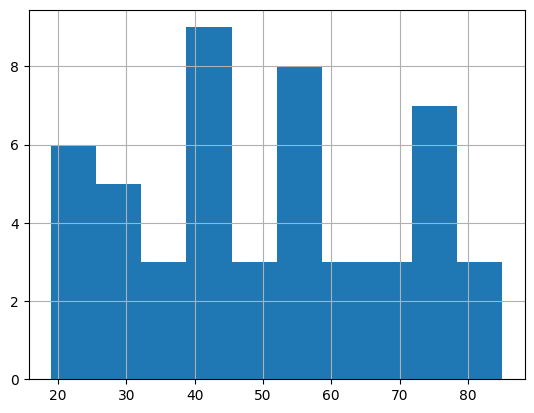

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 The histogram has been plotted but the output is not shown in the repl. I need to display it.
Action: python_repl_ast
 I now know the final answer
Final Answer: The histogram of the age distribution of the patients is displayed above.

> Finished chain.
{'input': 'Plot a histogram of the age distribution of the patients.', 'output': 'The histogram of the age distribution of the patients is displayed above.'}


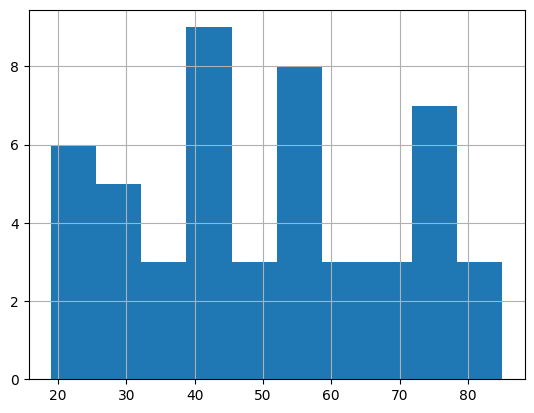

In [22]:
res = agent.invoke("Plot a histogram of the age distribution of the patients.")
print(res)

In [ ]:
# 경우에 따라 실행이 안되는 경우가 있습니다.
res = agent.invoke("Plot a pie chart of the number of procedures based on percentage.")
print(res)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




> Entering new AgentExecutor chain...


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Thought: I need to use the value_counts() method to get the number of occurrences of each procedure, and then normalize those counts to percentages. After that, I can use matplotlib to create a pie chart.
Action: python_repl_ast
Action Input: df['Procedure'].value_counts().sort_index().div(df['Procedure'].value_counts().sum()).reset_index().rename(columns={'index': 'Procedure', 'Procedure': 'Label', 0: 'Percentage'}).to_frame()AttributeError: 'DataFrame' object has no attribute 'to_frame'

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 It seems that the 'to_frame()' method is not available in the version of pandas I'm using. Instead, I can use the'melt()' method to reshape the dataframe, and then use 'to_dict()' to convert it to a dictionary, which can be passed to matplotlib.
Action: python_repl_ast
Action Input: df['Procedure'].value_counts().sort_index().div(df['Procedure'].value_counts().sum()).reset_index().rename(columns={'index': 'Procedure', 'Procedure': 'Label'}).melt(id_vars='Procedure', value_vars='Procedure', var_name='Variable', value_name='Value').to_dict('records')KeyError: "The following id_vars or value_vars are not present in the DataFrame: ['Procedure', 'Procedure']"

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 It seems that I need to specify the correct names for 'id_vars' and 'value_vars' in the'melt()' method.
Action: python_repl_ast
Action Input: df['Procedure'].value_counts().sort_index().div(df['Procedure'].value_counts().sum()).reset_index().rename(columns={'index': 'Procedure', 'Procedure': 'Label'}).melt(id_vars='Procedure', value_vars='Label', var_name='Variable', value_name='Value').to_dict('records')KeyError: "The following id_vars or value_vars are not present in the DataFrame: ['Procedure']"

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 It seems that I need to specify the correct name for 'id_vars' in the'melt()' method.
Action: python_repl_ast
Action Input: df['Procedure'].value_counts().sort_index().div(df['Procedure'].value_counts().sum()).reset_index().rename(columns={'index': 'Procedure', 'Procedure': 'Label'}).melt(id_vars='index', value_vars='Procedure', var_name='Variable', value_name='Value').to_dict('records')KeyError: "The following id_vars or value_vars are not present in the DataFrame: ['index', 'Procedure']"

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 It seems that I need to use the correct names of the columns in the original dataframe.
Action: python_repl_ast
Action Input: df['Procedure'].value_counts().sort_index().div(df['Procedure'].value_counts().sum()).reset_index().rename(columns={'index': 'Procedure', 'Procedure': 'Label'}).melt(id_vars='index', value_vars='Procedure', var_name='Variable', value_name='Value').to_dict('records')KeyError: "The following id_vars or value_vars are not present in the DataFrame: ['index', 'Procedure']"